Written by: Parsa Vahidi, Omid G. Sani  
Last update: Jan 10, 2024

# What is IPSID?

IPSID stands for "input preferential subspace identification", a method for dynamic modeling of time-series data and prioritizing the dynamics shared with another time-series, while time-series observations are driven by an external input. It extends PSID by supporting external inputs in the models. 

For example, given signals $y_k$ (e.g. neural signals) and $z_k$ (e.g behavior) and $u_k$ (e.g, external input such as sensory stimuli), IPSID learns a dynamic model for $y_k$ that satisfy the following two capabilities:
1) The intrinsic dynamics in $y_k$ (e.g. neural signals) are disentangled from dynamics of the external input (e.g., sensory information). This ensures that dynamics of external input are not misinterpreted as intrinsic dynamics in $y_k$. 
2) The intrinsic dynamics in $y_k$ that are relevant to $z_k$ (e.g behavior) are dissociated from other intrinsic dynamics in in $y_k$ and their learning is prioritized.

## Publications

For the full IPSID results in simulations and real neural data see the publication below:

Parsa Vahidi*, Omid G. Sani*, Maryam M. Shanechi. *Modeling and dissociation of intrinsic and input-driven neural population dynamics underlying behavior*. **Proceedings of National Academy of Science (PNAS)** (2024). https://doi.org/10.1073/pnas.2212887121 

<!--View-only full-text link: -->

Original preprint: https://doi.org/10.1101/2023.03.14.532554

<!-- You can also find a summary of the paper in the following Twitter thread:  -->


For the related prior publication on PSID, see:

Omid G. Sani, Hamidreza Abbaspourazad, Yan T. Wong, Bijan Pesaran, Maryam M. Shanechi. *Modeling behaviorally relevant neural dynamics enabled by preferential subspace identification*. **Nature Neuroscience** 24, 140–149 (2021). https://doi.org/10.1038/s41593-020-00733-0

For a similar tutorial on PSID, see:
https://github.dev/ShanechiLab/PyPSID/blob/main/source/PSID/example/PSID_tutorial.ipynb

# Installing IPSID
To use IPSID, you can either get the source code from [the PSID Github repository](https://github.com/ShanechiLab/PSID), or install it in your Python environment using pip:


```
pip install PSID
```

The above repository/library contain both PSID and IPSID. 

You can find the usage license in [LICENSE.md](https://github.com/ShanechiLab/PyPSID/blob/main/LICENSE.md). For this notebook, we will also start by installing PSID from pip.

In [1]:
!pip uninstall PSID --yes # Just to make sure we will have the latest version
!pip install PSID --upgrade

ERROR: Invalid requirement: '#'



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Using IPSID
## Modeling data with IPSID
To use IPSID, you first need to import the library by running:
```
import PSID
```
You can then use its main data modeling function as:
```
idSys = PSID.IPSID(y, z, u, nx=nx, n1=n1, i=i)
```
With the following arguments:
- `y` and `z` and `u` : Neural (e.g. LFP signal powers or spike counts) and behavioral data (e.g. hand position and velocity etc) and external input (e.g., task instruction sensory inputs) respectively. Dimensions are: time x data dimension (this can be changed with an optional argument documented in the code).
- `nx`: the total dimension of the latent state in the model.
- `n1`: the number of latent state dimensions that are going to be dedicated to behaviorally relevant neural dynamics.
- `i`: the subspace horizon used for modeling. There is more on the choice of `i` later in this notebook, but numbers such as 5 or 10 are typically suitable values for `i`.

And the following output:
- `idSys`: an object containing all the learned model parameters ($A$, $B$, $C_y$, $D_y$, $C_z$, etc) and some prediction, etc methods. There is more on the model structure later in this notebook.

## Modeling data with IPSID *with additional steps*
IPSID function includes extra settings that are useful for enabling the two additional steps.
1) *Additional step 1*: To enable, set remove_nonYrelated_fromX1=True and n_pre>0.
In case the input, $u_k$ influences behavior $z_k$ through pathways/regions that are neither recorded nor reflected in the recorded activity $y_k$. In such case, additional step 1 enables further dissociation of the intrinsic behaviorally relevant dynamics present in the recorded neural activity $y_k$ from the input-driven dynamics of behavior $z_k$ not present in the recorded neural activity $y_k$.
For more information on the additional steps please refer to the following section of (Vahidi, Sani, et al): *"IPSID Can Dissociate the Effects of Input on Behavior that Are*".


To enable this additional step 1, simply pass the following additional arguments
```
idSys = PSID.IPSID(Y, Z, U, nx=nx, n1=n1, remove_nonYrelated_inX1=True, n_pre=n_pre, i=i);  # with additional step 1
```
With the following arguments in addition to those introduced earlier:
- `remove_nonYrelated_inX1`: (default=False). If True and n_pre>0, enables *additional step 1*.
- `n_pre`: (default=np.inf) preprocessing dimension in *additional step 1*. If n_pre=0, preprocessing won't happen and $x_k^{(3)}$ won't be learned. See the documentation in the function for more details.


2) *Additional step 2* (optional): To enable, set remove_nonYrelated_fromX1=True and n_pre>0 and n3>0.
This step is optional and can be used to extract latent states $x_k^{(3)}$ corresponding to the input-driven behavior dynamics not present in neural activity. Incorporating this step could enhance behavior decoding when the additional steps 1 is used.

To also both additional steps, simply pass the following additional arguments (`n3`):
```
idSys = PSID.IPSID(Y, Z, U, nx=nx, n1=n1, remove_nonYrelated_inX1=True, n_pre=n_pre, n3=n3, i=i);  # with additional steps 1 and 2
```
- `n3`: (default=0) number of latent states $x_k^{(3)}$ in the optional *additional steps 2*.

 
## Using the model for Inference i.e., state estimation, and decoding
For a learned PSID model `idSys`, you can use the `predict` method to extract the latent state (`xPred`) and predict behavior (`zPred`) and neural activity (`yPred`) given any new neural data ($y_k$) and external input data ($u_k$) as:
```
zPred, yPred, xPred = idSys.predict(yTest, uTest)
```
With the argument:
- `yTest`: Neural activity `y` in the test data. Dimensions are: time x data dimension.
- `uTest`: Neural activity `u` in the test data. Dimensions are: time x data dimension.

And outputs (all dimensions are time x data dimension):
- `zPred`: Prediction of behavior using past neural activity and input at each data point.
- `yPred`: Prediction of neural activity using past neural activity and input at each data point.
- `xPred`: The latent state extracted at each data point.

We will next go through a complete example of using IPSID in data.

# A complete example for using IPSID
In this example, we will use IPSID to model some data. First, we import PSID and a few other useful tools from PSID and other libraries.
Example for using IPSID *with additional steps* is provided later in the notebook.

In [2]:
%load_ext autoreload
%autoreload 2

import argparse, sys, os
sys.path.insert(0, os.path.join('..', '..'))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

import PSID
from PSID.evaluation import evalPrediction
from PSID.MatHelper import loadmat

Let's start by loading an example model:

In [3]:
# Load data
sample_model_path = os.path.join(os.path.dirname(PSID.__file__), 'example', 'sample_model_IPSID.mat')
                 
print('Loading example model from {}'.format(sample_model_path))
data = loadmat(sample_model_path)
# This is an example model (shown in Fig. 2A) with 
# (a) 2 behaviorally relevant latent states $x_k^{(1)}$, (corresponding to intrinsic behaviorally relevant dynamics)
# (b) 4 other latent states $x_k^{(2)}$ (corresponding to other intrinsic dynamics)
# (c) 2 states that drive the external input (corresponding to input dynamics)

Loading example model from c:\codes\Repos\PSID\PyPSID-Main\source\PSID\example\..\..\PSID\example\sample_model_IPSID.mat


The IPSID model looks like this:

$$ x_{k+1} = A x_k + B u_k + w_k $$  

$$ y_k = C_y x_k + D_y u_k + v_k $$  

$$ z_k = C_z x_k + Dz u_k + \epsilon_k $$  

where $y_k \in \!R^{n_y}$ is the neural activity, $z_k \in \!R^{n_z}$ is the behavior, $u_k \in \!R^{n_u}$ is the external input and $x_k \in \!R^{n_x}$ is the latent state the describes the dynamics in both. Note that in general $y_k$ and $z_k$ could also be any other two signals (e.g. brain activity from two regions or even non-neural signals), but here we will refer these signals as neural activity and behavior, respectively. Importantly, IPSID learns the model in the following format

$$
x_k = \begin{bmatrix}
x_k^{(1)} \\
x_k^{(2)}
\end{bmatrix}
$$

where the behaviorally relevant dimensions of latent state ($x_k^{(1)} \in \!R^{n_1}$), which are those that drive $z_k$, are separated from the other dimensions ($x_k^{(2)} \in \!R^{n_2}$ with $n_2=n_x-n_1$). There are many equivalent ways of writing a latent state model such as this one, but IPSID learns the one that uses minimal number of dimensions to explain behavior as parsimoniously as possible. Critically, IPSID can learn this minimal model (with only $x_k^{(1)}$) without having to also learn the rest of the model (the $x_k^{(2)}$ part). This is the concept of prioritization and allows IPSID to learn the model more accurately, while requiring fewer training samples.


Before going further, let's generate some sample data from this model.

In [4]:
# Generating some sample data from this model
np.random.seed(42) # For exact reproducibility

# Prepare models
# Model of the dynamical input u
uSys = PSID.LSSM(params=data['uSys'])

# Model of the intrinsic dynamics
trueSys = PSID.LSSM(params=data['trueSys'])
trueSys.Dz = trueSys.dz

# Model of the z (behavior) dynamics that are not encoded in y (neural data), i.e. epsilon.
epsSys = PSID.LSSM(params=data['epsSys'])

def generate_data(N):
    u, _ = uSys.generateRealization(N)
    y, x = trueSys.generateRealization(N, u=u)
    z = (trueSys.Cz @ x.T).T + (trueSys.Dz @ u.T).T 

    _, x_eps = epsSys.generateRealization(N)
    z += (epsSys.Cz @ x_eps.T).T
    return y, z, u

N = int(2e5)
allYData, allZData, allUData = generate_data(N)

Given the above state-space model used by IPSID, it is important for the neural/behavior/input data to be zero-mean. 
IPSID by default internally removes the mean from the neural/behavior/input data and adds
it back to neural/behavior predictions, so the user does not need to handle this preprocessing. If the data is already zero-mean,
this mean-removal will simply subtract and add zeros to signals so everything will still work.
To cover this general case with data that is not zero-mean, let's artificially add some non-zero mean to the sample data:

In [5]:
# Just for this simulation, let's artificially add some non-zero mean to the sample data to cover the general case with non-zero-mean data:
YMean = 10*np.random.randn(allYData.shape[-1])
ZMean = 10*np.random.randn(allZData.shape[-1])
UMean = 10*np.random.randn(allUData.shape[-1])
allYData += YMean
allZData += ZMean
allUData += UMean

# Also save data means in the true model:
from PSID.PrepModel import PrepModel
trueSys.YPrepModel = PrepModel(mean=YMean, remove_mean=True)
trueSys.ZPrepModel = PrepModel(mean=ZMean, remove_mean=True)
trueSys.UPrepModel = PrepModel(mean=UMean, remove_mean=True)

Let's separate the data into training and test segments.

In [6]:
# Separate data into training and test data:
trainInds = np.arange(np.round(0.5*allYData.shape[0]), dtype=int)
testInds = np.arange(1+trainInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]
uTrain = allUData[trainInds, :]
uTest = allUData[testInds, :]

We will next use IPSID in two ways:  
1. Learn a model with a low-dimensional latent state that only focuses on learning the intrinsic behaviorally relevant neural dynamics (i.e. uses stage 1 of IPSID only).  
2. Learn a model that also learns other intrinsic neural dynamics (i.e. uses both stages of IPSID)

We will then plot the learned models' eigenvalues (the eigenvalues of the $A$ matrix) to show that IPSID learns the correct dynamics in each case.

First, let's learn a model with a 2 dimensional latent state that only learns the behaviorally relevant neural dynamics. For this, we pass the arguments nx=2 and n1=2 to the IPSID function:

In [7]:
## (Example 1) IPSID can be used to dissociate and extract only the 
# intrinsic behaviorally relevant latent states (with nx = n1 = 2)
idSys1 = PSID.IPSID(yTrain, zTrain, uTrain, nx=2, n1=2, i=10)
# You can also use the time_first=False argument if time is the second dimension:
# idSys1 = PSID.IPSID(yTrain.T, zTrain.T, uTrain.T, nx=2, n1=2, i=10, time_first=False) 

The IPSID learning function returns an object (here idSys1) that contains the learned model parameters and can be used to extract the latent states and decode behavior in new data. To do this, we use the 'predict' method in the learned model:

In [8]:
# Predict behavior using the learned model
zTestPred1, yTestPred1, xTestPred1 = idSys1.predict(yTest, uTest)

# Compute R2 of decoding
R2 = evalPrediction(zTest, zTestPred1, 'R2')

# Predict behavior using the true model for comparison
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal = trueSys.predict(yTest, uTest)
R2Ideal = evalPrediction(zTest, zTestPredIdeal, 'R2')

print('Behavior decoding R2:\n  IPSID => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(R2), np.mean(R2Ideal)) )

Behavior decoding R2:
  IPSID => 0.918, Ideal using true model => 0.925


We can see that the IPSID model with a 2D latent state is as accurate in explaining behavior as the full model that has a 6D latent state. This is because the other 4 latent state dimensions in the true model explain intrinsic dynamics that are exclusive to neural activity (i.e. are not behaviorally relevant).

Optionally, IPSID can also learn other latent states beyond the behaviorally relevant ones. For this, we pass the arguments nx=6 and n1=2 to the IPSID function:

In [9]:
## (Example 2) Optionally, IPSID can additionally also learn the 
# behaviorally irrelevant latent states (with nx = 6, n1 = 2)
idSys2 = PSID.IPSID(yTrain, zTrain, uTrain, nx=6, n1=2, i=10)

# In addition to ideal behavior decoding, this model will also have ideal neural self-prediction 
zTestPred2, yTestPred2, xTestPred2 = idSys2.predict(yTest, uTest)
yR2 = evalPrediction(yTest, yTestPred2, 'R2')
yR2Ideal = evalPrediction(yTest, yTestPredIdeal, 'R2')
print('Neural self-prediction R2:\n  IPSID => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(yR2), np.mean(yR2Ideal)))

Neural self-prediction R2:
  IPSID => 0.753, Ideal using true model => 0.753


We can see that in this case, the model learned by IPSID (which now has a 6D latent state) is also as good as the true model in terms of explaining neural activity. 


Finally, we can plot the eigenvalues of the $A$ matrix in each of the learned models and compare them with the eigenvalues of the $A$ matrix in the true model to see the accurate learning of intrinsic behaviorally relevant (and optionally the other intrinsic) dynamics by IPSID. 

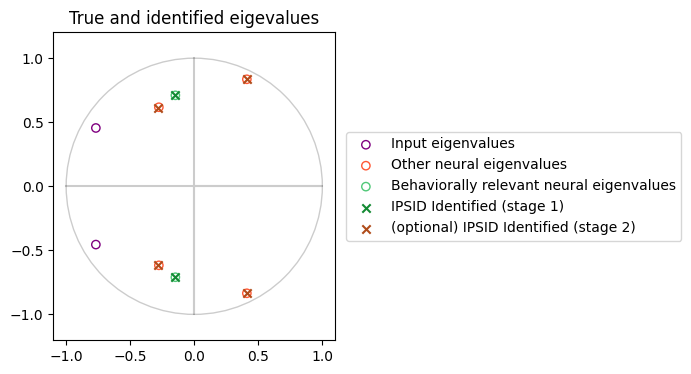

In [10]:
# #########################################
# Plot the true and identified eigenvalues    

# (Example 1) Eigenvalues when only learning behaviorally relevant states
idEigs1 = np.linalg.eig(idSys1.A)[0]

# (Example 2) Additional eigenvalues when also learning behaviorally irrelevant states
# The identified model is already in form of Eq. 1, with behaviorally irrelevant states 
# coming as the last 4 dimensions of the states in the identified model
idEigs2 = np.linalg.eig(idSys2.A[2:, 2:])[0]

relevantDims = trueSys.zDims - 1 # Dimensions that drive both behavior and neural activity
irrelevantDims = [x for x in np.arange(trueSys.state_dim, dtype=int) if x not in relevantDims] # Dimensions that only drive the neural activity
trueEigsRelevant = np.linalg.eig(trueSys.A[np.ix_(relevantDims, relevantDims)])[0]
trueEigsIrrelevant = np.linalg.eig(trueSys.A[np.ix_(irrelevantDims, irrelevantDims)])[0]
trueEigsInput = np.linalg.eig(uSys.A)[0]

fig = plt.figure(figsize=(8, 4))
axs = fig.subplots(1, 2)
axs[1].remove() 
ax = axs[0]
ax.axis('equal')
ax.add_patch( patches.Circle((0,0), radius=1, fill=False, color='black', alpha=0.2, ls='-') )
ax.plot([-1,1,0,0,0], [0,0,0,-1,1], color='black', alpha=0.2, ls='-')
ax.scatter(np.real(trueEigsInput), np.imag(trueEigsInput), marker='o', edgecolors='#800080', facecolors='none', label='Input eigenvalues')
ax.scatter(np.real(trueEigsIrrelevant), np.imag(trueEigsIrrelevant), marker='o', edgecolors='#FF5733', facecolors='none', label='Other neural eigenvalues')
ax.scatter(np.real(trueEigsRelevant), np.imag(trueEigsRelevant), marker='o', edgecolors='#50C878', facecolors='none', label='Behaviorally relevant neural eigenvalues')
ax.scatter(np.real(idEigs1), np.imag(idEigs1), marker='x', facecolors='#138a33', label='IPSID Identified (stage 1)')
ax.scatter(np.real(idEigs2), np.imag(idEigs2), marker='x', facecolors='#b04c1a', label='(optional) IPSID Identified (stage 2)')
ax.set_title('True and identified eigevalues')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

# Using IPSID with trial based data
You can also use IPSID if the data is available in separate chunks, for example across many trials. To do this, simply pass a python list with the data in each chunk/trial as the argument to IPSID. The trials don't need to have the same number of samples either. 

Below is an example, where we break the same data as before in small chunks of random length, and then pass it to IPSID.

In [11]:
## (Example 3) IPSID can be used if data is available in discontinuous segments (e.g. different trials)
# In this case, y, z and u data segments must be provided as elements of a list
# Trials do not need to have the same number of samples
# Here, for example assume that trials start at every 1000 samples.
# And each each trial has a random length of 900 to 990 samples
trialStartInds = np.arange(0, allYData.shape[0]-1000, 1000)
trialDurRange = np.array([900, 990])
trialDur = np.random.randint(low=trialDurRange[0], high=1+trialDurRange[1], size=trialStartInds.shape)

# We can cut the same data into trials
# trialInds = [trialStartInds[ti]+np.arange(trialDur[ti]) for ti in range(trialStartInds.size)] 
# yTrials = [allYData[trialIndsThis, :] for trialIndsThis in trialInds] 
# zTrials = [allZData[trialIndsThis, :] for trialIndsThis in trialInds] 
# uTrials = [allUData[trialIndsThis, :] for trialIndsThis in trialInds] 

# Or alternatively we can generate some new trial based data, which would give the data a more
# realistic consistency in how each trial starts
yTrials, zTrials, uTrials = [], [], []
for trial_samples in trialDur:
    yThis, zThis, uThis = generate_data(trial_samples)
    yTrials.append(yThis) # We don't need to add YMean to y since it is already added by trueSys2's YPredModel
    zTrials.append(zThis+ZMean)
    uTrials.append(uThis+UMean)

# Separate trials into training and test trials:
trainInds = np.arange(np.round(0.5*len(yTrials)), dtype=int)
testInds = np.arange(1+trainInds[-1], len(yTrials))
yTrainTrials = [yTrials[ti] for ti in trainInds]
yTestTrials = [yTrials[ti] for ti in testInds]
zTrainTrials = [zTrials[ti] for ti in trainInds]
zTestTrials = [zTrials[ti] for ti in testInds]
uTrainTrials = [uTrials[ti] for ti in trainInds]
uTestTrials = [uTrials[ti] for ti in testInds]

idSys3 = PSID.IPSID(yTrainTrials, zTrainTrials, uTrainTrials, nx=2, n1=2, i=10)

zPredTrials, yPredTrials, xPredTrials = idSys3.predict(yTestTrials, uTestTrials)
zPredTrialsIdeal, yPredTrialsIdeal, xPredTrialsIdeal = trueSys.predict(yTestTrials, uTestTrials)
zTestA = np.concatenate( zTestTrials, axis=0)
zPredA = np.concatenate( zPredTrials, axis=0)
zPredIdealA = np.concatenate( zPredTrialsIdeal, axis=0)

R2TrialBased = evalPrediction(zTestA, zPredA, 'R2')
R2TrialBasedIdeal = evalPrediction(zTestA, zPredIdealA, 'R2')

print('Behavior decoding R2 (trial-based learning/decoding):\n  IPSID => {:.3g}, Ideal using true model = {:.3g}'.format(np.mean(R2TrialBased), np.mean(R2TrialBasedIdeal)) )

Behavior decoding R2 (trial-based learning/decoding):
  IPSID => 0.919, Ideal using true model = 0.92


# How to pick the state dimensions `nx` and `n1`?
`nx` determines the total dimension of the latent state and `n1` determines how many of those dimensions will be prioritizing the inclusion of behaviorally relevant neural dynamics (i.e. will be extracted using stage 1 of IPSID). So the values that you would select for these hyperparameters depend on the goal of modeling and on the data. Some examples use cases are:
- If you want to perform dimension reduction, `nx` will be your desired target dimension. For example, to reduce dimension to 2 to plot low-dimensional visualizations of neural activity, you would use `nx=2`. Now if you want to reduce dimension while preserving as much behaviorally relevant neural dynamics as possible, you would use `n1=nx`. 
- If you want to find the best fit to data overall, you can perform a grid search over values of `nx` and `n1` and pick the value that achieves the best performance metric in the training data. For example, you could pick the `nx` and `n1` pair that achieves the best cross-validated behavior decoding in an inner-cross-validation within the training data.

# How to pick the horizon `i`?
The horizon `i` does not affect the model structure and only affects the intermediate linear algebra operations that IPSID performs during the learning of the model. Nevertheless, different values of `i` may have different model learning performance. `i` needs to be at least 2, but also also determines the maximum `n1` and `nx` that can be used per: 
```
n1 <= nz * i
nx <= ny * i
```
So if you have a low dimensional y or z, you typically would choose larger values for `i`, and vice versa. It is also possible to select the best performing `i` via an inner cross-validation approach similar to `nx` and `n1` above.

# A complete example for using IPSID *with additional steps*
In this example, we will use IPSID and its *additional steps* to model some data. 

Let's start by loading another example model where the external input $u_k$ additionally influences behavior $z_k$ through pathways not reflected in recorded neural activity $y_k$.

In [12]:
# Load data
sample_model_path = os.path.join(os.path.dirname(PSID.__file__), 'example', 'sample_model_IPSID_add_step.mat')
print('Loading example model from {}'.format(sample_model_path))
data2 = loadmat(sample_model_path)
# This is an example model (shown in Fig. 3) with 
# (a) 2 behaviorally relevant latent states, x_k^(1), encoded in neural activity y_k (corresponding to intrinsic behaviorally relevant neural dynamics), 
# (b) 2 other latent states, x_k^(2), encoded in neural activity y_k (corresponding to other intrinsic dynamics),
# (c) 2 states that drive the external input (corresponding to input dynamics)
# (d) 2 behaviorally relevant latent states, x_k^(3), driven by the input u_k but not encoded in neural activity y_k

Loading example model from c:\codes\Repos\PSID\PyPSID-Main\source\PSID\example\..\..\PSID\example\sample_model_IPSID_add_step.mat


In this scenario, the  IPSID model including *additional steps* looks like this:

$$ x_{k+1} = A x_k + B u_k + w_k $$  

$$ y_k = C_y x_k + D_y u_k + v_k $$  

$$ z_k = C_z x_k + Dz u_k + \epsilon_k $$  

where as before, $y_k \in \!R^{n_y}$ is the neural activity, $z_k \in \!R^{n_z}$ is the behavior, $u_k \in \!R^{n_u}$ is the external input and $x_k \in \!R^{n_x}$ is the latent state the describes the dynamics in both. But importantly, IPSID *with additional steps* learns the model in the following format

$$
x_k = \begin{bmatrix}
x_k^{(1)} \\
x_k^{(2)} \\
x_k^{(3)}
\end{bmatrix}
$$

where in addition to before, the dimensions of latent state that drive $z_k$ but not $y_k$ ($x_k^{(3)} \in \!R^{n_3}$) are further modeled and separated from the dimensions of latent state that drive both $y_k$ and $z_k$ ($x_k^{(1)} \in \!R^{n_1}$).


Before going further, let's generate some sample data from this model.

In [13]:
# Generating some sample data from this model
np.random.seed(42) # For exact reproducibility

# Prepare models
# Model of the dynamical input u
uSys2 = PSID.LSSM(params=data2['uSys'])
Au = uSys2.A

# Model of the intrinsic dynamics
trueSys2 = PSID.LSSM(params=data2['trueSys'])

def generate_data2(N):
    u, _ = uSys2.generateRealization(N)
    y, x = trueSys2.generateRealization(N, u=u)
    z = (trueSys2.Cz @ x.T).T
    
    return y, z, u

N = int(2e5)
allYData, allZData, allUData = generate_data2(N)

Given the above state-space model used by IPSID, it is important for the neural/behavior/input data to be zero-mean. 
IPSID by default internally removes the mean from the neural/behavior/input data and adds
it back to neural/behavior predictions, so the user does not need to handle this preprocessing. If the data is already zero-mean,
this mean-removal will simply subtract and add zeros to signals so everything will still work.
To cover this general case with data that is not zero-mean, let's artificially add some non-zero mean to the sample data:

In [14]:
YMean = 10*np.random.randn(allYData.shape[-1])
ZMean = 10*np.random.randn(allZData.shape[-1])
UMean = 10*np.random.randn(allUData.shape[-1])
allYData += YMean
allZData += ZMean
allUData += UMean

# Also reflect this in the true model:
from PSID.PrepModel import PrepModel
trueSys2.YPrepModel = PrepModel(mean=YMean, remove_mean=True)
trueSys2.ZPrepModel = PrepModel(mean=ZMean, remove_mean=True)
trueSys2.UPrepModel = PrepModel(mean=UMean, remove_mean=True)

Let's separate the data into training and test segments.

In [15]:
trainInds = np.arange(np.round(0.5*allYData.shape[0]), dtype=int)
testInds = np.arange(1+trainInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]
uTrain = allUData[trainInds, :]
uTest = allUData[testInds, :]

We will next use IPSID  in two ways:  
1. Learn a model with a low-dimensional latent state that only focuses on learning the intrinsic behaviorally relevant neural dynamics (i.e., uses both stages of IPSID and *additional steps 1 only*).  
2. Learn a model that also learns other intrinsic neural dynamics (i.e., uses both stages of IPSID and both *additional steps 1, 2*)

We will then plot the learned models' eigenvalues (the eigenvalues of the $A$ matrix) to show that IPSID *with additional steps* learns the correct dynamics in each case.

First let's learn a model that includes all three type of states $x_k^{(1)}$, $x_k^{(2)}$, $x_k^{(3)}$. To do so, we pass the arguments `nx=6`, `n1=2`, `n3=2`, `remove_nonYrelated_fromX1=True`, and `n_pre=4`. `n_pre` should be equal to the total number of dimensions driving neural activity $y_k$ (which in this example is dim($x_k^{(1)}$)+dim($x_k^{(2)}$) = 2 + 2 = 4). 

In [16]:
# all latent states [x1;x2,x3] (with nx=6, n1=2, n3=2)
idSys4 = PSID.IPSID(yTrain, zTrain, uTrain, nx=6, n1=2, i=10, remove_nonYrelated_fromX1=True, n_pre=4, n3=2) # n_pre should be equal to true n1+true n2

Next, we only use the *first additional step* and exclude *additional step 2* (which means excluding $x_k^{(3)}$). To do so, we pass the arguments `nx=4`, `n1=2`, `n3=0`, `remove_nonYrelated_fromX1=True`, and `n_pre=4`. 

In [17]:
# For comparison, let's also learn a model without the additional step 2 (only [x1;x2])
idSys4_low_dim = PSID.IPSID(yTrain, zTrain, uTrain, nx=4, n1=2, i=10, remove_nonYrelated_fromX1=True, n_pre=4, n3=0) # n_pre should be equal to true n1+true n2

We now perform inference using both learned models and compare to the ideal performance obtained by using the know true model.

In [18]:
# Predict behavior and neural activity using the learned model with both additional steps
zTestPred4, yTestPred4, xTestPred3 = idSys4.predict(yTest, uTest)
# Compute R2 of decoding and neural self-prediction
R2 = evalPrediction(zTest, zTestPred4, 'R2')
yR2 = evalPrediction(yTest, yTestPred4, 'R2')

# Predict behavior and neural activity using the learned model without additional step 2
zTestPred4_low_dim, yTestPred4_low_dim, xTestPred4_low_dim = idSys4_low_dim.predict(yTest, uTest)
R2_low_dim = evalPrediction(zTest, zTestPred4_low_dim, 'R2')
yR2_low_dim = evalPrediction(yTest, yTestPred4_low_dim, 'R2')

# Predict using the true model for comparison
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal = trueSys2.predict(yTest, uTest)
R2Ideal = evalPrediction(zTest, zTestPredIdeal, 'R2')
yR2Ideal = evalPrediction(yTest, yTestPredIdeal, 'R2')

print('Behavior decoding R2:\n  IPSID => {:.3g}, IPSID (without additional step 2) => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(R2), np.mean(R2_low_dim), np.mean(R2Ideal)) )
print('Neural self-prediction R2:\n  IPSID => {:.3g}, IPSID (without additional step 2) => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(yR2), np.mean(yR2_low_dim), np.mean(yR2Ideal)) )


Behavior decoding R2:
  IPSID => 0.93, IPSID (without additional step 2) => 0.473, Ideal using true model => 0.985
Neural self-prediction R2:
  IPSID => 0.985, IPSID (without additional step 2) => 0.985, Ideal using true model => 0.988


We can see that, both models self-predict neural activity as accurately as the true model. Also, the model learned by IPSID with both additional steps boosts the behavior decoding performance compared to the one without additional step 2.

Finally, we can plot the eigenvalues of the $A$ matrix in each of the learned models and compare them with the eigenvalues of the $A$ matrix in the true model to see the accurate learning of intrinsic behaviorally relevant (and optionally the other) intrinsic dynamics by IPSID *with additional steps*.

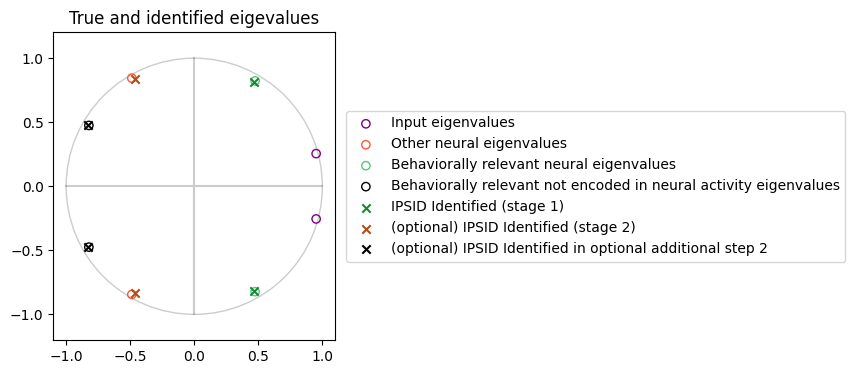

In [19]:
# Plot the true and identified eigenvalues for IPSID with additional steps   

# Intrinsic behaviorally relevant eigenvalues encoded in neural activity
idEigs1 = np.linalg.eig(idSys4_low_dim.A[:2,:2])[0]

# Other intrinsic eigenvalues encoded in neural activity
idEigs2 = np.linalg.eig(idSys4_low_dim.A[2:, 2:])[0]

# Behaviorally relevant eigenvalues not encoded in neural activity
idEigs3 = np.linalg.eig(idSys4.A[4:, 4:])[0]

relevantDims = trueSys2.zDims - 1 # Dimensions that drive both behavior and neural activity
irrelevantDims = [2, 3] # Dimensions that only drive the neural activity
trueEigsRelevant = np.linalg.eig(trueSys2.A[np.ix_(relevantDims, relevantDims)])[0]
trueEigsIrrelevant = np.linalg.eig(trueSys2.A[np.ix_(irrelevantDims, irrelevantDims)])[0]
trueEigsInput = np.linalg.eig(Au)[0]
trueEigsNonEncoded = np.linalg.eig(trueSys2.A[4:,4:])[0]


fig = plt.figure(figsize=(8, 4))
axs = fig.subplots(1, 2)
axs[1].remove() 
ax = axs[0]
ax.axis('equal')
ax.add_patch( patches.Circle((0,0), radius=1, fill=False, color='black', alpha=0.2, ls='-') )
ax.plot([-1,1,0,0,0], [0,0,0,-1,1], color='black', alpha=0.2, ls='-')
ax.scatter(np.real(trueEigsInput), np.imag(trueEigsInput), marker='o', edgecolors='#800080', facecolors='none', label='Input eigenvalues')
ax.scatter(np.real(trueEigsIrrelevant), np.imag(trueEigsIrrelevant), marker='o', edgecolors='#FF5733', facecolors='none', label='Other neural eigenvalues')
ax.scatter(np.real(trueEigsRelevant), np.imag(trueEigsRelevant), marker='o', edgecolors='#50C878', facecolors='none', label='Behaviorally relevant neural eigenvalues')
ax.scatter(np.real(trueEigsNonEncoded), np.imag(trueEigsNonEncoded), marker='o', edgecolors='#000000', facecolors='none', label='Behaviorally relevant not encoded in neural activity eigenvalues')
ax.scatter(np.real(idEigs1), np.imag(idEigs1), marker='x', facecolors='#138a33', label='IPSID Identified (stage 1)')
ax.scatter(np.real(idEigs2), np.imag(idEigs2), marker='x', facecolors='#b04c1a', label='(optional) IPSID Identified (stage 2)')
ax.scatter(np.real(idEigs3), np.imag(idEigs3), marker='x', facecolors='#000000', label='(optional) IPSID Identified in optional additional step 2')

ax.set_title('True and identified eigevalues')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

# Using IPSID *with additional steps* with trial based data
Again, exactly as noted above, IPSID with additional steps also supports data that is available in separate chunks, for example across many trials. To do this, again, simply pass a python list with the data in each chunk/trial as the argument to IPSID. The trials don't need to have the same number of samples either. 

Below is an example, where we break the same data as before in small chunks of random length, and then pass it to IPSID with additional steps.

In [30]:
## (Example 4) IPSID with additional steps can also be used if data is available 
# in discontinuous segments (e.g. different trials)
# In this case, y, z and u data segments must be provided as elements of a list
# Trials do not need to have the same number of samples
# Here, for example assume that trials start at every 1000 samples.
# And each each trial has a random length of 900 to 990 samples
trialStartInds = np.arange(0, allYData.shape[0]-1000, 1000)
trialDurRange = np.array([900, 990])
trialDur = np.random.randint(low=trialDurRange[0], high=1+trialDurRange[1], size=trialStartInds.shape)

# We can cut the same data into trials
# trialInds = [trialStartInds[ti]+np.arange(trialDur[ti]) for ti in range(trialStartInds.size)] 
# yTrials = [allYData[trialIndsThis, :] for trialIndsThis in trialInds] 
# zTrials = [allZData[trialIndsThis, :] for trialIndsThis in trialInds] 
# uTrials = [allUData[trialIndsThis, :] for trialIndsThis in trialInds] 

# Or alternatively we can generate some new trial based data, which would give the data a more
# realistic consistency in how each trial starts
yTrials, zTrials, uTrials = [], [], []
for trial_samples in trialDur:
    yThis, zThis, uThis = generate_data2(trial_samples)
    yTrials.append(yThis) # We don't need to add YMean to y since it is already added by trueSys2's YPredModel
    zTrials.append(zThis+ZMean)
    uTrials.append(uThis+UMean)

# Separate data into training and test data:
trainInds = np.arange(np.round(0.5*len(yTrials)), dtype=int)
testInds = np.arange(1+trainInds[-1], len(yTrials))
yTrainTrials = [yTrials[ti] for ti in trainInds]
yTestTrials = [yTrials[ti] for ti in testInds]
zTrainTrials = [zTrials[ti] for ti in trainInds]
zTestTrials = [zTrials[ti] for ti in testInds]
uTrainTrials = [uTrials[ti] for ti in trainInds]
uTestTrials = [uTrials[ti] for ti in testInds]

idSys4 = PSID.IPSID(yTrainTrials, zTrainTrials, uTrainTrials, nx=6, n1=2, i=10, remove_nonYrelated_fromX1=True, n_pre=4, n3=2) # n_pre should be equal to true n1+true n2

zPredTrials, yPredTrials, xPredTrials = idSys4.predict(yTestTrials, uTestTrials)
zPredA = np.concatenate( zPredTrials, axis=0)
yPredA = np.concatenate( yPredTrials, axis=0)

zPredTrialsIdeal, yPredTrialsIdeal, xPredTrialsIdeal = trueSys2.predict(yTestTrials, uTestTrials)
zPredIdealA = np.concatenate( zPredTrialsIdeal, axis=0)
yPredIdealA = np.concatenate( yPredTrialsIdeal, axis=0)

zTestA = np.concatenate( zTestTrials, axis=0)
yTestA = np.concatenate( yTestTrials, axis=0)
R2TrialBased = evalPrediction(zTestA, zPredA, 'R2')
yR2TrialBased = evalPrediction(yTestA, yPredA, 'R2')
R2TrialBasedIdeal = evalPrediction(zTestA, zPredIdealA, 'R2')
yR2TrialBasedIdeal = evalPrediction(yTestA, yPredIdealA, 'R2')

# For comparison, let's also learn a model without the additional step 2 (only [x1;x2])
idSys4_low_dim = PSID.IPSID(yTrainTrials, zTrainTrials, uTrainTrials, nx=4, n1=2, i=10, remove_nonYrelated_fromX1=True, n_pre=4, n3=0) # n_pre should be equal to true n1+true n2
zPredTrials_low_dim, yPredTrials_low_dim, xPredTrials_low_dim = idSys4_low_dim.predict(yTestTrials, uTestTrials)
zPredA_low_dim = np.concatenate( zPredTrials_low_dim, axis=0)
yPredA_low_dim = np.concatenate( yPredTrials_low_dim, axis=0)
R2TrialBased_low_dim = evalPrediction(zTestA, zPredA_low_dim, 'R2')
yR2TrialBased_low_dim = evalPrediction(yTestA, yPredA_low_dim, 'R2')

print('\nBehavior decoding R2 (trial-based learning/decoding):\n  IPSID => {:.3g}, IPSID (without additional step 2) => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(R2TrialBased), np.mean(R2TrialBased_low_dim), np.mean(R2TrialBasedIdeal)) )
print('Neural self-prediction R2 (trial-based learning/decoding):\n  IPSID => {:.3g}, IPSID (without additional step 2) => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(yR2TrialBased), np.mean(yR2TrialBased_low_dim), np.mean(yR2TrialBasedIdeal)) )



Behavior decoding R2 (trial-based learning/decoding):
  IPSID => 0.929, IPSID (without additional step 2) => 0.475, Ideal using true model => 0.984
Neural self-prediction R2 (trial-based learning/decoding):
  IPSID => 0.985, IPSID (without additional step 2) => 0.985, Ideal using true model => 0.988


# Licence
Copyright (c) 2020 University of Southern California  
See full notice in [LICENSE.md](https://github.com/ShanechiLab/PyPSID/blob/main/LICENSE.md)  
Parsa Vahidi, Omid G. Sani and Maryam M. Shanechi  
Shanechi Lab, University of Southern California